In [1]:
import os

import pandas
import numpy
import scipy
import scipy.stats
import scipy.ndimage

import math

%matplotlib widget
import matplotlib
import matplotlib.pyplot
import matplotlib.patches

import cv2

import tqdm

import activity_experiments_python.ampconfig_management as AM 
import activity_experiments_python.signalsconfig_management as SCM 


In [2]:
root_path = '/Users/matthieu/Documents/proto3/visualization/queen/video_act/samples/queen_samples/'
annotations_file = root_path + 'queen_and_vibs_v2.csv'

FPS         = 30
RESAMPLING_FLAG = True
SYNCHRO_FLAG    = True

data_raw = pandas.read_csv(annotations_file)
data_raw

exp_data = []
for id, row in data_raw.iterrows():

    # Determine if queen annot or vibs annot
    video_file = row['video name']
    exp_time = video_file.split('_')[-1].split('.')[0]
    if 'rpi2' in video_file :
        file_type = 'Q'
    elif 'rpi3' in video_file:
        file_type = 'V'
    else :
        continue

    # Remove empty annotations
    annot_pos = row['marked bee positions']
    if annot_pos == '[]':
        continue

    # Check if datapoint already exists
    datapt = []
    datapt_id = None
    for i, dp in enumerate(exp_data):
        if dp['time']==exp_time:
            datapt = dp
            datapt_id = i
    if datapt_id == None:
        datapt                  = {'time': exp_time}
        datapt['vfname']        = video_file.split('/')[-1]
        datapt['queen_pos']     = []
        datapt['queen_pos_ts']  = []
        datapt['led_shift_ts']  = []
    
    # Fill datapoint characteristics
    if file_type == 'Q':
        annot_pos   = row['marked bee positions']
        annot_ts    = row['bee position timestamps']
        annot_pos_list  = [[int(val) for val in tup.split(',')] for tup in annot_pos.translate({ord(i): None for i in '][( '})[:-1].split('),')]
        annot_ts_list   = [int(x) for x in annot_ts.translate({ord(i): None for i in '][ '}).split(',')]

        _ = [datapt['queen_pos'].append(x) for x in annot_pos_list]
        _ = [datapt['queen_pos_ts'].append(x) for x in annot_ts_list]
    elif file_type == 'V':
        annot_shift = row['bee position timestamps']
        annot_shift_list   = [int(x) for x in annot_shift.translate({ord(i): None for i in '][ '}).split(',')]
        datapt['led_shift_ts']  = annot_shift_list
        datapt['startvibs_ts']  = annot_shift_list[1]
        datapt['stopvibs_ts']   = annot_shift_list[3]
        

    # Append or replace datapoint
    if datapt_id == None :
        exp_data.append(datapt)
    else :
        exp_data[datapt_id] = datapt

# cleaning
ts_new = numpy.array(range(90*2))*15
for dp_i, dp in enumerate(exp_data):
    # print(dp['queen_pos_ts'])
    # dp['queen_pos']     = dp['queen_pos']
    # dp['queen_pos_ts']  = dp['queen_pos_ts']
    
    # sorting by times
    dp['queen_pos']     = numpy.array([x for _,x in sorted(zip(dp['queen_pos_ts'],dp['queen_pos']))])
    dp['queen_pos_ts']  = numpy.array(sorted(dp['queen_pos_ts']))


    if SYNCHRO_FLAG :
        dp['queen_pos_ts'] = dp['queen_pos_ts']-dp['startvibs_ts']+15*FPS
        nb_to_drop = int(numpy.array([1 for x in dp['queen_pos_ts'] if x<0]).sum())
        nb_to_drop_end = int(numpy.array([1 for x in dp['queen_pos_ts'] if x>61*FPS-1]).sum())
        dp['queen_pos_ts'] = dp['queen_pos_ts'][nb_to_drop:-nb_to_drop_end]
        dp['queen_pos'] = dp['queen_pos'][nb_to_drop:-nb_to_drop_end]
        # dp['stopvibs_ts']   = dp['stopvibs_ts']-dp['startvibs_ts']+15*FPS
        dp['stopvibs_ts']   = 30*FPS
        dp['startvibs_ts']  = 15*FPS

    if RESAMPLING_FLAG:
        # print(numpy.argwhere(ts_new > numpy.min(dp['queen_pos_ts'])))
        id_min = numpy.argwhere(ts_new >= numpy.min(dp['queen_pos_ts']))[0][0]
        id_max = numpy.argwhere(ts_new <= numpy.max(dp['queen_pos_ts']))[-1][0]+1
        ts_new_adapted = ts_new[id_min:id_max]
        dp['queen_pos'] = [numpy.expand_dims(pos, axis=1) for pos in [numpy.interp(ts_new_adapted, dp['queen_pos_ts'], dp['queen_pos'][:, 0]), numpy.interp(ts_new_adapted, dp['queen_pos_ts'], dp['queen_pos'][:, 1])]]
        dp['queen_pos'] = numpy.concatenate(dp['queen_pos'], axis=1)
        dp['queen_pos_ts'] = ts_new_adapted
        
    print(dp['queen_pos_ts'][-1])
        
exp_data = pandas.DataFrame.from_dict(exp_data)
exp_data

1815
1815
1815
1815
1815
1815
1815
1815
1815
1815


time                              vfname  \
0  230610-111811-utc  v_hive1_rpi2_230610-111811-utc.mp4   
1  230611-120012-utc  v_hive1_rpi2_230611-120012-utc.mp4   
2  230611-120211-utc  v_hive1_rpi2_230611-120211-utc.mp4   
3  230612-080012-utc  v_hive1_rpi2_230612-080012-utc.mp4   
4  230612-080411-utc  v_hive1_rpi2_230612-080411-utc.mp4   
5  230612-081211-utc  v_hive1_rpi2_230612-081211-utc.mp4   
6  230612-090411-utc  v_hive1_rpi2_230612-090411-utc.mp4   
7  230612-101011-utc  v_hive1_rpi2_230612-101011-utc.mp4   
8  230606-090411-utc  v_hive1_rpi3_230606-090411-utc.mp4   
9  230606-150011-utc  v_hive1_rpi3_230606-150011-utc.mp4   

                                           queen_pos  \
0  [[1018.6666666666666, 601.6666666666666], [102...   
1  [[274.0, 490.6666666666667], [265.666666666666...   
2  [[351.0, 795.0], [354.0, 778.0], [358.0, 772.0...   
3  [[823.7333333333333, 637.7333333333333], [824....   
4  [[1049.8, 721.0], [1039.6, 728.2], [1028.2, 72...   
5  [[641.4, 451.2], [656.4, 450.8], [655.0, 460.4...   
6  [[653.4666666666667, 819.8666666666667], [649....   
7  [[653.8, 450.0], [658.8, 449.4], [656.0, 450.6...   
8  [[1445.3333333333333, 364.6666666666667], [144...   
9  [[1018.6, 565.2], [1015.0, 576.8], [1024.4, 57...   

                                        queen_pos_ts          led_shift_ts  \
0  [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 1...  [521, 520, 947, 948]   
1  [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 1...  [521, 520, 947, 948]   
2  [255, 270, 285, 300, 315, 330, 345, 360, 375, ...  [521, 522, 947, 948]   
3  [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 1...  [520, 521, 946, 947]   
4  [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 1...  [520, 521, 947, 948]   
5  [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 1...  [521, 522, 947, 948]   
6  [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 1...  [520, 521, 946, 947]   
7  [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 1...  [521, 522, 948, 949]   
8  [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 1...  [521, 522, 948, 949]   
9  [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 1...  [521, 522, 947, 948]   

   startvibs_ts  stopvibs_ts  
0           450          900  
1           450          900  
2           450          900  
3           450          900  
4           450          900  
5           450          900  
6           450          900  
7           450          900  
8           450          900  
9           450          900

In [3]:
configs_path = root_path + 'configs/'
amp2_conf = AM.extract_amp_config(configs_path + 'amp2_config.json')
sigs_conf = SCM.extract_signals_config(configs_path + 'signals_config.json')
frame_pos = {"x":[71,1468], "y":[291,1125]}

N_X_ACTS = 4
N_Y_ACTS = 2
x_boundaries = numpy.linspace(frame_pos['x'][0], frame_pos['x'][1], N_X_ACTS+1).astype(numpy.int32)
y_boundaries = numpy.linspace(frame_pos['y'][0], frame_pos['y'][1], N_Y_ACTS+1).astype(numpy.int32)

actuators_mapping = numpy.array([
    [4, 5, 6, 7],
    [3, 2, 1, 0]
])
actuators_positions = {}
for i in range(actuators_mapping.shape[0]):
    for j in range(actuators_mapping.shape[1]):
        act_id = actuators_mapping[i,j]
        actuators_positions[act_id] = [int((x_boundaries[j]+x_boundaries[j+1])/2), int((y_boundaries[i]+y_boundaries[i+1])/2)]

actuators_commands = {
    'v_hive1_rpi2_230610-111811-utc.mp4': {'trigs':[8, 8]},
    'v_hive1_rpi2_230611-120012-utc.mp4': {'trigs':[11, 3]},
    'v_hive1_rpi2_230611-120211-utc.mp4': {'trigs':[11, 0]},
    'v_hive1_rpi2_230612-080012-utc.mp4': {'trigs':[6, 6]},
    'v_hive1_rpi2_230612-080411-utc.mp4': {'trigs':[8, 8]},
    'v_hive1_rpi2_230612-081211-utc.mp4': {'trigs':[6, 1]},
    'v_hive1_rpi2_230612-090411-utc.mp4': {'trigs':[7, 2]},
    'v_hive1_rpi2_230612-101011-utc.mp4': {'trigs':[7, 7]},
    'v_hive1_rpi2_230612-090411-utc.mp4': {'trigs':[0, 5]},
    'v_hive1_rpi2_230612-101011-utc.mp4': {'trigs':[1, 1]}
}


samples = []
for key in actuators_commands.keys():
    sample = {}
    sample['fname'] = str(key)
    sample['trigs'] = actuators_commands[key]['trigs']
    sample['freq'] = 0
    sample['sigs_transmitted']=[]
    sample['acts_used']=[]

    if sample['trigs'][0] != 11:
        sig_0 = sigs_conf['SB0'][str(sample['trigs'][0])]
        if sig_0['1'] != {}:
            sample['sigs_transmitted'].append('sig1')
            _ = [sample['acts_used'].append(act) for act in amp2_conf['sig1']]
            sample['freq'] = sig_0['1']['frequency']
        else :
            sample['sigs_transmitted'].append('sig2')
            _ = [sample['acts_used'].append(act) for act in amp2_conf['sig2']]
            sample['freq'] = sig_0['2']['frequency']
        
    else :
        sig_0 = {}
    
    if sample['trigs'][1] != 11:
        sig_1 = sigs_conf['SB1'][str(sample['trigs'][1])]
        if sig_1['1'] != {}:
            sample['sigs_transmitted'].append('sig3')
            _ = [sample['acts_used'].append(act) for act in amp2_conf['sig3']]
            sample['freq'] = sig_1['1']['frequency']
        else :
            sample['sigs_transmitted'].append('sig4')
            _ = [sample['acts_used'].append(act) for act in amp2_conf['sig4']]
            sample['freq'] = sig_1['2']['frequency']
    else :
        sig_1 = {}

    samples.append(sample)

actuators_commands = pandas.DataFrame.from_records(samples)
actuators_commands

fname    trigs  freq sigs_transmitted  \
0  v_hive1_rpi2_230610-111811-utc.mp4   [8, 8]  1750     [sig2, sig4]   
1  v_hive1_rpi2_230611-120012-utc.mp4  [11, 3]  1750           [sig3]   
2  v_hive1_rpi2_230611-120211-utc.mp4  [11, 0]  1000           [sig3]   
3  v_hive1_rpi2_230612-080012-utc.mp4   [6, 6]  1250     [sig2, sig4]   
4  v_hive1_rpi2_230612-080411-utc.mp4   [8, 8]  1750     [sig2, sig4]   
5  v_hive1_rpi2_230612-081211-utc.mp4   [6, 1]  1250     [sig2, sig3]   
6  v_hive1_rpi2_230612-090411-utc.mp4   [0, 5]  1000     [sig1, sig4]   
7  v_hive1_rpi2_230612-101011-utc.mp4   [1, 1]  1250     [sig1, sig3]   

      acts_used  
0  [4, 5, 6, 7]  
1        [2, 3]  
2        [2, 3]  
3  [4, 5, 6, 7]  
4  [4, 5, 6, 7]  
5  [4, 5, 2, 3]  
6  [0, 1, 6, 7]  
7  [0, 1, 2, 3]

In [4]:
# Speed computation
PIX_TO_MM   = 1550/420 # to be determined more accurately

mmdists = []
pspeeds = []
mspeeds = []
tspeeds = []

ave_speed_B = []
ave_speed_D = []
ave_speed_A = []
# ave_speed_A2 = []
ave_speed_T = []

for rid, row in exp_data.iterrows():
    pos     = row.queen_pos        # pixels
    t_pos   = row.queen_pos_ts/30  # seconds

    i_pos   = pos[:,0]          # pixels
    j_pos   = pos[:,1]          # pixels
    
    x_pos = i_pos*PIX_TO_MM     # mm
    y_pos = j_pos*PIX_TO_MM     # mm

    t_spe   = (t_pos[1:] + t_pos[:-1]) / 2
    m_dist  = numpy.sqrt((i_pos[1:] - i_pos[:-1])*(i_pos[1:] - i_pos[:-1]) + (j_pos[1:] - j_pos[:-1])*(j_pos[1:] - j_pos[:-1]))*PIX_TO_MM
    p_spe   = numpy.sqrt((i_pos[1:] - i_pos[:-1])*(i_pos[1:] - i_pos[:-1]) + (j_pos[1:] - j_pos[:-1])*(j_pos[1:] - j_pos[:-1])) / (t_pos[1:] - t_pos[:-1])
    mm_spe  = p_spe*PIX_TO_MM

    mmdists.append(m_dist)       # pixels
    pspeeds.append(p_spe)       # pixels/seconds
    mspeeds.append(mm_spe)      # mm/seconds
    tspeeds.append(t_spe)       # seconds

    ts_risingedge   = numpy.argwhere(t_spe > row.startvibs_ts/FPS)[0][0]
    ts_fallingedge  = numpy.argwhere(t_spe > row.stopvibs_ts/FPS)[0][0]
    
    ave_speed_B.append(numpy.mean(p_spe[:ts_risingedge]))
    ave_speed_D.append(numpy.mean(p_spe[ts_risingedge:ts_fallingedge]))
    ave_speed_A.append(numpy.mean(p_spe[ts_fallingedge:]))
    ave_speed_T.append(numpy.mean(p_spe))

exp_data['mm_dist'] = mmdists
exp_data['p_speed'] = pspeeds
exp_data['m_speed'] = mspeeds
exp_data['t_speed'] = tspeeds

exp_data['ave_spe_B'] = ave_speed_B
exp_data['ave_spe_D'] = ave_speed_D
exp_data['ave_spe_A'] = ave_speed_A
exp_data['ave_spe_T'] = ave_speed_T

exp_data = exp_data.sort_values('ave_spe_T')

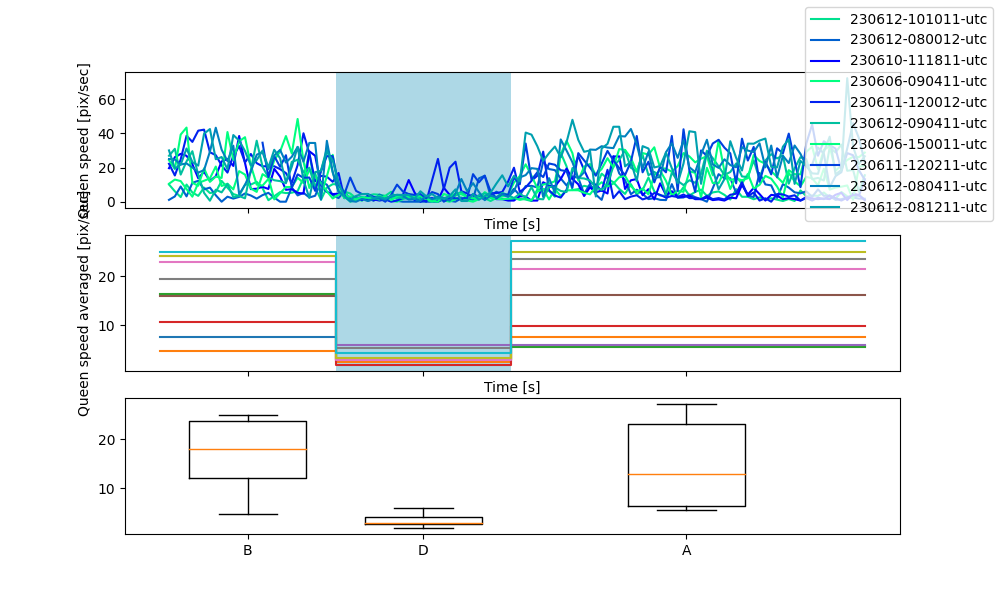

In [5]:
fig, ax = matplotlib.pyplot.subplots(3, 1, figsize=(10, 6), sharex=True)
cmap = matplotlib.cm.get_cmap('winter') 

for rid, row in exp_data.iterrows():
    # Speeds plot for each experiment
    ax[0].plot(row.t_speed, row.p_speed, c=cmap(float(rid)/float(8)), label='{}'.format(row.time))
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Queen speed [pix/sec]')
    
    # average speeds plot for each experiment
    ax[1].step([0, row.startvibs_ts/FPS, row.stopvibs_ts/FPS, row.t_speed[-1]], [row.ave_spe_B, row.ave_spe_D, row.ave_spe_A, row.ave_spe_A], where='post')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Queen speed averaged [pix/sec]')

# boxplots of averaged speeds
act_periods = ['B', 'D', 'A']
pos_periods = [7.5, 22.5, 45]
wid_periods = [10, 10, 10]
# for i in range(len(act_periods)):
ax[2].boxplot([exp_data['ave_spe_B'].values, exp_data['ave_spe_D'].values, exp_data['ave_spe_A'].values], positions=pos_periods, labels=act_periods, widths=wid_periods)
ax[2].set_xlim(ax[0].get_xlim())


xmin = exp_data.startvibs_ts.mean() / FPS
xmax = exp_data.stopvibs_ts.mean()  / FPS

ax[0].axvspan(xmin, xmax, facecolor='lightblue')
ax[1].axvspan(xmin, xmax, facecolor='lightblue')
fig.legend()

In [6]:
# Ranksum tests for comparison
print('Ranksums test (Before VS During) : {}'.format(scipy.stats.ranksums(exp_data['ave_spe_B'].values, exp_data['ave_spe_D'].values)))
print('Ranksums test (During VS After) : {}'.format(scipy.stats.ranksums(exp_data['ave_spe_D'].values, exp_data['ave_spe_A'].values)))
print('Ranksums test (Before VS After) : {}'.format(scipy.stats.ranksums(exp_data['ave_spe_B'].values, exp_data['ave_spe_A'].values)))

Ranksums test (Before VS During) : RanksumsResult(statistic=3.6284589408885815, pvalue=0.00028511808363161265)
Ranksums test (During VS After) : RanksumsResult(statistic=-3.6284589408885815, pvalue=0.00028511808363161265)
Ranksums test (Before VS After) : RanksumsResult(statistic=0.5291502622129182, pvalue=0.5967012167293563)


# Figure

In [7]:
# extract video frame
def extract_video_frame(video, cropX=None, cropY=None, frame_of_interest=0):

    cap = cv2.VideoCapture(video)
    
    frame_count = 0
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        frame_count += 1
        if ret == False or frame_count > frame_of_interest:
            xy = [0,0]
            if not(cropX is None):
                frame_crop = frame[cropX[0]:cropX[1],:]
                xy[1]=cropX[0]
            else:
                frame_crop=frame
            if not(cropY is None):
                frame_crop = frame_crop[:,cropY[0]:cropY[1]]
                xy[0]=cropY[0]
                
            break

    return frame_crop

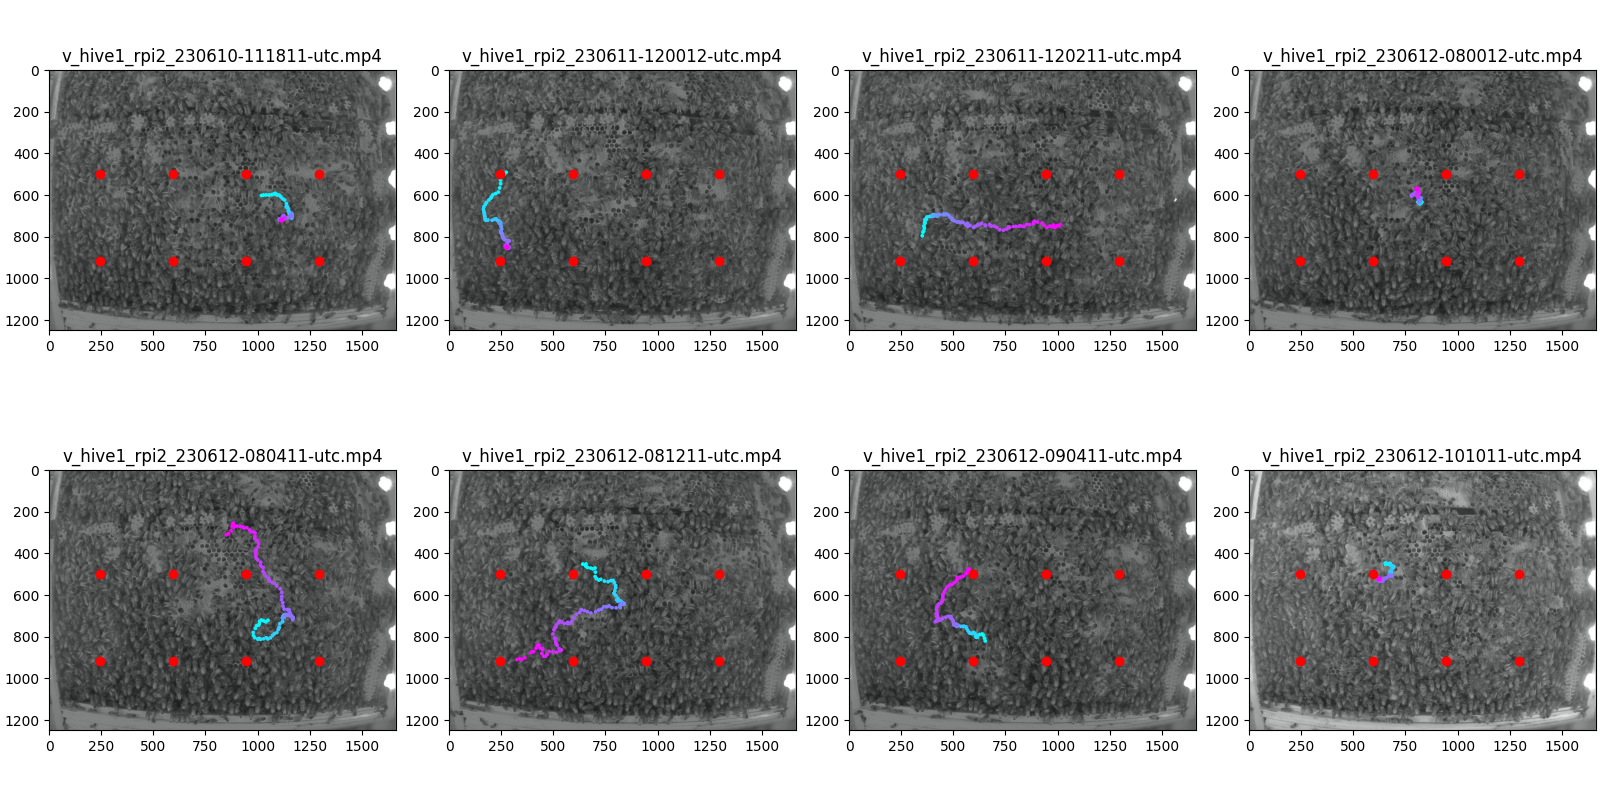

In [8]:
# Sample picture for background
videos_path = root_path + 'rpi2_vids/'
video_id = 0
frame_id = 10
video_files = sorted([vid for vid in os.listdir(videos_path) if vid.endswith('.mp4')])
video_file = video_files[0]

frame = extract_video_frame(videos_path + video_file, frame_of_interest=0)

GRID = [2, 4]

fig, ax = matplotlib.pyplot.subplots(GRID[0], GRID[1], figsize=(16,8), constrained_layout=True)
for i in range(GRID[0]):
    for j in range(GRID[1]):
        id = i*GRID[1]+j
        video_fname = video_files[id]
        frame = extract_video_frame(videos_path+video_fname, frame_of_interest=10)
        queen_trajectory = exp_data[exp_data.vfname == video_fname].iloc[0].queen_pos
        queen_traj_ts = exp_data[exp_data.vfname == video_fname].iloc[0].queen_pos_ts

        # rect = matplotlib.patches.Rectangle([frame_pos['y'][0],frame_pos['x'][0]], width=frame_pos['y'][1]-frame_pos['y'][0], height=frame_pos['x'][1]-frame_pos['x'][0], edgecolor='r', facecolor='none')
        ax[i,j].imshow(frame)
        ax[i,j].title.set_text(video_files[id])
        ax[i,j].scatter(queen_trajectory[:, 0], queen_trajectory[:, 1], c=queen_traj_ts, cmap='cool', s=3)
        for act in actuators_positions.keys():
            ax[i,j].scatter(actuators_positions[act][0], actuators_positions[act][1], c='r')
        # ax[i,j].add_patch(rect)


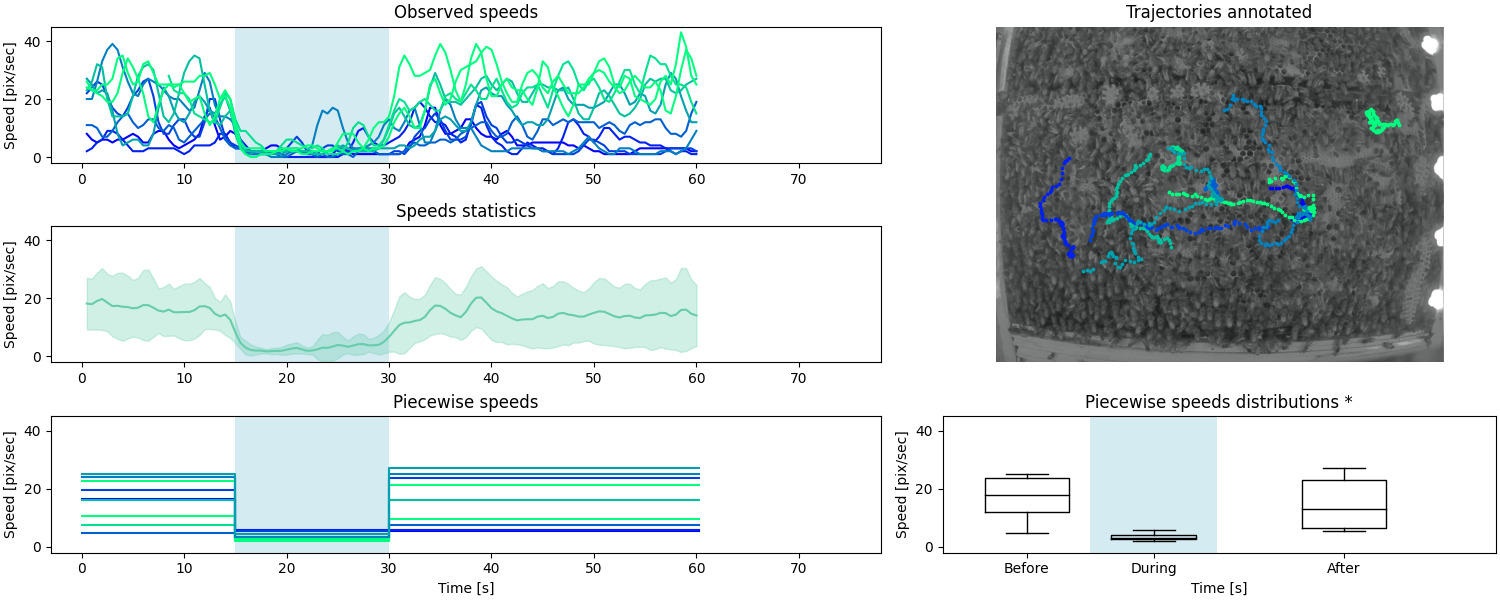

In [9]:
fig = matplotlib.pyplot.figure(figsize=(15, 6), constrained_layout=True)

gs = fig.add_gridspec(3,2, width_ratios=[60, 40])
ax = [[[],[]],[[]],[[],[]]]
ax[0][0] = fig.add_subplot(gs[0, 0])
ax[1][0] = fig.add_subplot(gs[1, 0])
ax[2][0] = fig.add_subplot(gs[2, 0])
ax[0][1] = fig.add_subplot(gs[0:2, 1])
ax[2][1] = fig.add_subplot(gs[2, 1])


ax[0][0].axvspan(xmin, xmax, facecolor='lightblue', alpha=0.5)
ax[1][0].axvspan(xmin, xmax, facecolor='lightblue', alpha=0.5)
ax[2][0].axvspan(xmin, xmax, facecolor='lightblue', alpha=0.5)
ax[2][1].axvspan(xmin, xmax, facecolor='lightblue', alpha=0.5)

cmap = matplotlib.cm.get_cmap('winter') 

# Data handling for spread display
data_pts = pandas.DataFrame({'ts':ts_new})
for rid, row in exp_data.iterrows():
    id_min = numpy.argwhere(ts_new == row['queen_pos_ts'][0])[0,0]
    id_max = numpy.argwhere(ts_new == row['queen_pos_ts'][-1])[0,0]

    data_line = numpy.empty_like(ts_new)
    data_line.fill(-1)

    speed_line = scipy.ndimage.gaussian_filter(row['p_speed'], sigma=1)
    data_line[id_min:id_max] = speed_line

    data_pts['Pt'+str(rid)] = data_line

data_pts = data_pts.replace(-1, numpy.nan)


video_fname = video_files[0]
frame = extract_video_frame(videos_path+video_fname, frame_of_interest=0)
ax[0][1].imshow(frame)

for rid, row in exp_data.iterrows():
    # Shows trajectories on frame
    queen_trajectory = row.queen_pos
    ax[0][1].scatter(queen_trajectory[:, 0], queen_trajectory[:, 1],  color=cmap(float(rid)/float(8)), s=3)
    
    # average speeds plot for each experiment
    ax[2][0].step([0, row.startvibs_ts/FPS, row.stopvibs_ts/FPS, row.t_speed[-1]], [row.ave_spe_B, row.ave_spe_D, row.ave_spe_A, row.ave_spe_A], where='post', c=cmap(float(rid)/float(8)))

# Speeds plot for each experiment
for dp in range(10):
    ax[0][0].plot(data_pts.ts/30, data_pts.iloc[:,dp+1], c=cmap(float(dp)/float(8)))#, label='{}'.format(row.time))

y_values = data_pts.iloc[:,1:].mean(axis=1)
y_errors = data_pts.iloc[:,1:].std(axis=1)
ax[1][0].plot(data_pts.ts/30, y_values, color='mediumaquamarine')
ax[1][0].fill_between(data_pts.ts/30, y_values-y_errors, y_values+y_errors, color='mediumaquamarine', alpha=.3)


# boxplots of averaged speeds
act_periods = ['Before', 'During', 'After']
pos_periods = [7.5, 22.5, 45]
wid_periods = [10, 10, 10]
# for i in range(len(act_periods)):
ax[2][1].boxplot([exp_data['ave_spe_B'].values, exp_data['ave_spe_D'].values, exp_data['ave_spe_A'].values], positions=pos_periods, labels=act_periods, widths=wid_periods, medianprops=dict(color='black'))
ax[2][1].set_xlim(ax[0][0].get_xlim())


xmin = exp_data.startvibs_ts.mean() / FPS
xmax = exp_data.stopvibs_ts.mean()  / FPS

# Titles
ax[0][0].title.set_text('Observed speeds')
ax[1][0].title.set_text('Speeds statistics')
ax[2][0].title.set_text('Piecewise speeds')
ax[0][1].title.set_text('Trajectories annotated')

BD_rst = scipy.stats.ranksums(exp_data['ave_spe_B'].values, exp_data['ave_spe_D'].values)
DA_rst = scipy.stats.ranksums(exp_data['ave_spe_D'].values, exp_data['ave_spe_A'].values)
BA_rst = scipy.stats.ranksums(exp_data['ave_spe_B'].values, exp_data['ave_spe_A'].values)
# ax[2][1].title.set_text('Speeds distributions * (B/D:{0:1.4f}, D/A:{1:1.4f}, B/A:{2:1.4f})'.format(BD_rst[1], DA_rst[1], BA_rst[1]))
ax[2][1].title.set_text('Piecewise speeds distributions *')

# Axes labels
ax[0][0].set_ylabel('Speed [pix/sec]')
ax[1][0].set_ylabel('Speed [pix/sec]')
_ = _ = _ = ax[2][0].set_xlabel('Time [s]')
_ = ax[2][0].set_ylabel('Speed [pix/sec]')
_ = ax[0][1].set_axis_off()
_ = ax[2][1].set_xlabel('Time [s]')
_ = ax[2][1].set_ylabel('Speed [pix/sec]')

# Axes limits
XLIM_TIME = [-3, 78]
_ = ax[0][0].set_xlim(XLIM_TIME)
_ = ax[1][0].set_xlim(XLIM_TIME)
_ = ax[2][0].set_xlim(XLIM_TIME)

YLIM_SPEED = [-2, 45]
_ = ax[0][0].set_ylim(YLIM_SPEED)
_ = ax[1][0].set_ylim(YLIM_SPEED)
_ = ax[2][0].set_ylim(YLIM_SPEED)
_ = ax[2][1].set_ylim(YLIM_SPEED)

# Grids
# _ = ax[0][0].grid()
# _ = ax[1][0].grid()
# _ = ax[2][0].grid()
# _ = ax[2][1].grid()


(180,) [ nan  4.   3.   4.   8.   5.   7.   6.   8.  10.   9.   7.  10.  11.
  8.   7.   9.   8.5  6.5  7.   8.5  7.5  8.   8.   3.5  4.   2.5  4.
  7.   5.5  3.   0.5  1.   1.   1.   1.   0.5  0.5  0.   1.   1.   1.
  0.5  0.5  1.   0.5  1.   1.   1.5  1.   1.5  1.   1.   1.   0.5  0.5
  1.   1.   1.5  2.5  5.   6.5  7.   7.5  5.5  5.5  4.   5.   8.5  6.5
  3.   5.   7.   6.   4.5  5.   2.5  6.5  7.5  8.5  8.5  9.   9.5  8.5
  8.   8.   8.   6.   6.   7.   9.5 10.   9.5 11.5  9.5  9.   5.5  9.5
  8.   6.   9.5  9.5  9.5  8.5 10.  10.   9.5 11.   9.5  8.5 10.  10.5
 11.5 11.5 11.   9.5 11.5 11.  10.  11.  11.5  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


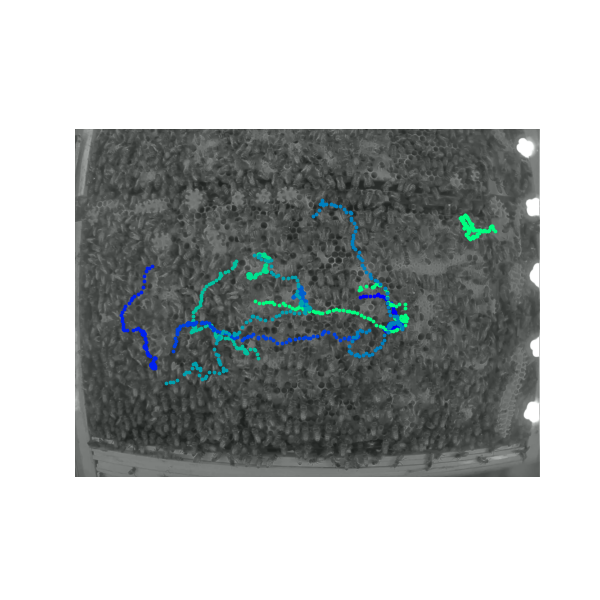

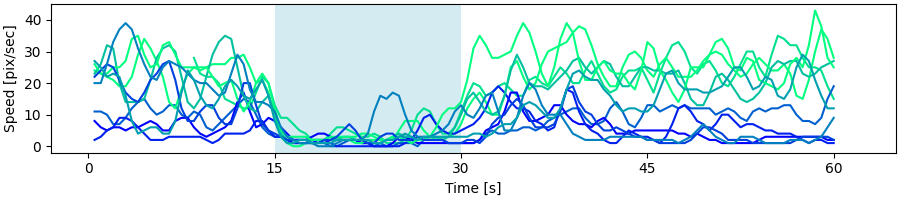

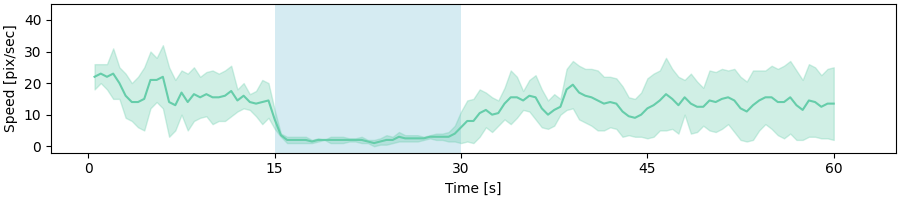

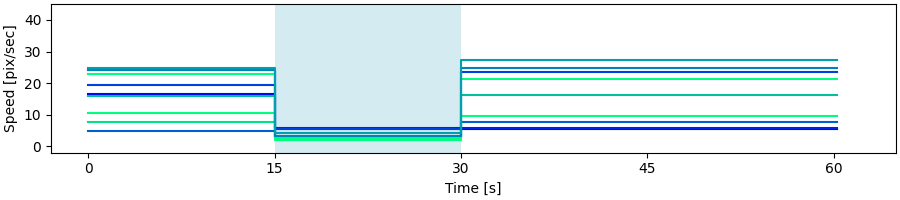

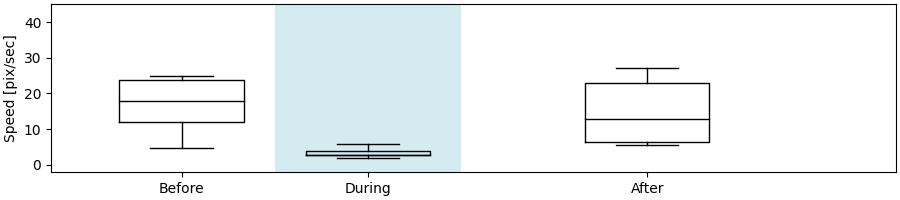

In [15]:
cmap = matplotlib.cm.get_cmap('winter') 

fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(6, 6))

# Data handling for spread display
data_pts = pandas.DataFrame({'ts':ts_new})
for rid, row in exp_data.iterrows():
    id_min = numpy.argwhere(ts_new == row['queen_pos_ts'][0])[0,0]
    id_max = numpy.argwhere(ts_new == row['queen_pos_ts'][-1])[0,0]

    data_line = numpy.empty_like(ts_new)
    data_line.fill(-1)

    speed_line = scipy.ndimage.gaussian_filter(row['p_speed'], sigma=1)
    data_line[id_min:id_max] = speed_line

    data_pts['Pt'+str(rid)] = data_line

data_pts = data_pts.replace(-1, numpy.nan)


video_fname = video_files[0]
frame = extract_video_frame(videos_path+video_fname, frame_of_interest=0)
ax.imshow(frame)

for rid, row in exp_data.iterrows():
    # Shows trajectories on frame
    queen_trajectory = row.queen_pos
    ax.scatter(queen_trajectory[:, 0], queen_trajectory[:, 1],  color=cmap(float(rid)/float(8)), s=3)

_ = ax.set_axis_off()



fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(9, 2), constrained_layout=True)
ax.axvspan(xmin, xmax, facecolor='lightblue', alpha=0.5)
# Speeds plot for each experiment
for dp, _ in exp_data.iterrows():
    ax.plot(data_pts.ts/30, data_pts.iloc[:,dp+1], c=cmap(float(dp)/float(8)))#, label='{}'.format(row.time))

_ = ax.set_xlabel('Time [s]')
ax.set_ylabel('Speed [pix/sec]')
_ = ax.set_xticks([0, 15, 30, 45, 60])
XLIM_TIME = [-3, 65]
_ = ax.set_xlim(XLIM_TIME)
YLIM_SPEED = [-2, 45]
_ = ax.set_ylim(YLIM_SPEED)



fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(9, 2), constrained_layout=True)
ax.axvspan(xmin, xmax, facecolor='lightblue', alpha=0.5)

y_values = data_pts.iloc[:,1:].median(axis=1)
y_errors = scipy.stats.median_abs_deviation(data_pts.iloc[:,1:].values, axis=1, nan_policy='omit')
print(y_values.shape, y_errors)
ax.plot(data_pts.ts/30, y_values, color='mediumaquamarine')
ax.fill_between(data_pts.ts/30, y_values-y_errors, y_values+y_errors, color='mediumaquamarine', alpha=.3)

_ = ax.set_xlabel('Time [s]')
_ = ax.set_ylabel('Speed [pix/sec]')
_ = ax.set_xticks([0, 15, 30, 45, 60])
_ = ax.set_xlim(XLIM_TIME)
_ = ax.set_ylim(YLIM_SPEED)



fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(9, 2), constrained_layout=True)
ax.axvspan(xmin, xmax, facecolor='lightblue', alpha=0.5)

for rid, row in exp_data.iterrows():
    # average speeds plot for each experiment
    ax.step([0, row.startvibs_ts/FPS, row.stopvibs_ts/FPS, row.t_speed[-1]], [row.ave_spe_B, row.ave_spe_D, row.ave_spe_A, row.ave_spe_A], where='post', c=cmap(float(rid)/float(8)))

_ = ax.set_ylabel('Speed [pix/sec]')
_ = ax.set_xticks([0, 15, 30, 45, 60])
_ = ax.set_xlabel('Time [s]')
_ = ax.set_xlim(XLIM_TIME)
_ = ax.set_ylim(YLIM_SPEED)



fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(9, 2), constrained_layout=True)
ax.axvspan(xmin, xmax, facecolor='lightblue', alpha=0.5)

# boxplots of averaged speeds
act_periods = ['Before', 'During', 'After']
pos_periods = [7.5, 22.5, 45]
wid_periods = [10, 10, 10]
# for i in range(len(act_periods)):
ax.boxplot([exp_data['ave_spe_B'].values, exp_data['ave_spe_D'].values, exp_data['ave_spe_A'].values], positions=pos_periods, labels=act_periods, widths=wid_periods, medianprops=dict(color='black'))
_ = ax.set_ylabel('Speed [pix/sec]')
_ = ax.set_xlim(XLIM_TIME)
_ = ax.set_ylim(YLIM_SPEED)

In [14]:
data_pts

ts  Pt7  Pt3   Pt0   Pt8   Pt1   Pt6   Pt9  Pt2   Pt4   Pt5
0       0  NaN  NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN
1      15  8.0  2.0  22.0  11.0  20.0  27.0  23.0  NaN  24.0  26.0
2      30  6.0  3.0  24.0  11.0  20.0  25.0  26.0  NaN  23.0  23.0
3      45  5.0  5.0  26.0  10.0  26.0  22.0  32.0  NaN  22.0  23.0
4      60  6.0  6.0  25.0   7.0  33.0  23.0  31.0  NaN  21.0  25.0
..    ...  ...  ...   ...   ...   ...   ...   ...  ...   ...   ...
175  2625  NaN  NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN
176  2640  NaN  NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN
177  2655  NaN  NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN
178  2670  NaN  NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN
179  2685  NaN  NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN

[180 rows x 11 columns]